In [1]:
##更改为三节点连线和臀，左右膝盖的三角形特征,多图片循环,并且连接箭头线
import cv2
import time
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
'''
## Specify the model to be used
COCO and MPI askire body pose estimation model. COCO has 18 points and MPI has 15 points as output.

HAND is hand keypoints estimation model. It has 22 points as output

Ensure that the model files are available in the folders.
'''
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    
    keypointsMapping = ['Head', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'Chest', 'Background']

    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6],
                  [6,7], [1,14], [14,8], [8,9], [9,10], [14,11],
                  [11,12], [12,13]]
# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
'''
mapIdx = [[15,16], [17,18], [19,20], [21,22], [23,24], [25,26], 
          [27,28], [29,30], [31,32], [33,34], [35,36], [37,38], 
          [39,40], [41,42]]


POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]
'''
mapIdx = [[16,17], [18,19], [20,21], [22,23], [24,25], [26,27],
          [28,29], [30,31], [32,33], [34,35], [36,37], [38,39], 
          [40,41],[42,43]]


colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0]]



In [2]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    _, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

#### Let us load an image with multiple people and check what the model sees

In [3]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        
        #print(k)
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            #print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    #print(valid_pairs)
    return valid_pairs, invalid_pairs


In [4]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 16))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 13:
                    row = -1 * np.ones(16)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [5]:
# This function 创建了一组新的骨骼节点，以臀部节点固定在为中心C_point定为（150,150）
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def MakeNewPoints( point_8n, C_point):
    New_point_8n=point_8n
    for ii in  range(len(point_8n)):
            x_bta=C_point[0]-point_8n[ii][2][0]
            y_bta=C_point[1]-point_8n[ii][2][1]
            for jj in  range(len(point_8n[ii])):
                if(point_8n[ii][jj][0]>0):
                    New_point_8n[ii][jj]=(point_8n[ii][jj][0]+x_bta, point_8n[ii][jj][1]+y_bta)                
    return New_point_8n

In [6]:
def MakeAngle0( P_c,p_f,p_b ):
    Angle=0 
    dx1 = p_f[0] - P_c[0] 
    dy1 = p_f[1] - P_c[1]
    
    dx2 = p_b[0] - P_c[0] 
    dy2 = p_b[1] - P_c[1]
    c = np.Sqrt(dx1 * dx1 + dy1 * dy1) * np.Sqrt(dx2 * dx2 + dy2 * dy2)
    if(c==0):
        Angle=-1  
    else:
        Angle = np.arccos((dx1 * dx2 + dy1 * dy2) / c)
    return Angle 

In [7]:
def MakeAngle( P_c,p_f,p_b ):
    Angle=0 
   # print( P_c,p_f,p_b)
    dx1 = p_f[0] - P_c[0] 
    dy1 = p_f[1] - P_c[1]
    
    dx2 = p_b[0] - P_c[0] 
    dy2 = p_b[1] - P_c[1]
    if (dx1==0 ):
        k1=0
    else:
        k1 = dy1/(float(dx1)) 
    if (dx2==0 ):
        k2=0   
    else:  
        k2 = dy2/(float(dx2))
    Angle=int(math.fabs(np.arctan((k1-k2)/(float(1 + k1*k2)))*180/np.pi)+0.5)
    return Angle 

In [8]:
# This function 创建了一组新的骨骼节点，以臀部节点固定在为中心C_point定为（150,150）
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def MakeNewPoints1( point_8n, C_point):
    New_point_8n=point_8n
    if (len(point_8n)==len(C_point)):
        R=len(point_8n)
    else:
        R=min(len(C_point),len(point_8n))
    #print(R)
    for ii in  range(R):#存在序号错位的可能性
            x_bta=C_point[ii][0]-point_8n[ii][2][0]
            y_bta=C_point[ii][1]-point_8n[ii][2][1]
            
            if abs(x_bta)>100 and  (len(C_point)>len(point_8n)):
               # print (x_bta,ii)
                x_bta=C_point[ii+1][0]-point_8n[ii][2][0]
                y_bta=C_point[ii+1][1]-point_8n[ii][2][1]
            for jj in  range(len(point_8n[ii])):
                if(point_8n[ii][jj][0]>0):
                    New_point_8n[ii][jj]=(point_8n[ii][jj][0]+x_bta, point_8n[ii][jj][1]+y_bta+20)                
    return New_point_8n

In [9]:
# This function 创建了一组新的骨骼节点，以臀部节点固定在为中心C_point定为（150,150）
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def MakeNewPoints2( point_8n, C_point):
    New_point_8n=point_8n
    for jj in  range (len(point_8n)):#存在序号错位的可能性
        x_bta=[]
        y_bta=[]
        x_bta1=[]
        y_bta1=[]
        for ii in  C_point:#存在序号错位的可能性 
            x_bta1.append(ii[0]-point_8n[jj][2][0])
            y_bta1.append(ii[1]-point_8n[jj][2][1])
            x_bta.append(abs(ii[0]-point_8n[jj][2][0]))
            y_bta.append(abs(ii[1]-point_8n[jj][2][1]))
        x_bta0 = min(x_bta)
        min_index = x_bta.index(x_bta0)
        #print(min_index)
        for kk in  range(len(point_8n[jj])):
            if(point_8n[jj][kk][0]>0):
                New_point_8n[jj][kk]=(point_8n[jj][kk][0]+x_bta1[min_index], point_8n[jj][kk][1]+y_bta1[min_index])                
    #print(New_point_8n)
    return New_point_8n
            

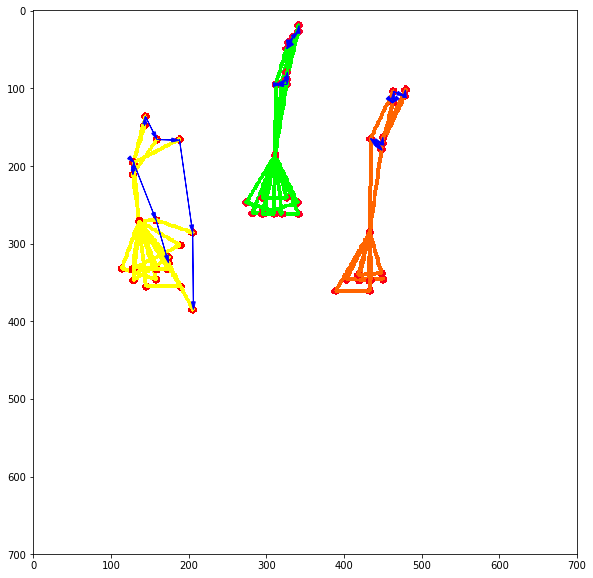

In [20]:
#读文件下图片
import os 

plt.figure(figsize=[10,10]) 
conut=0
Angle=0
#C_point=(150,250)
root_path = "C:/Users/zhang/OpenPose1/"
dir = root_path+"IMG_3514_2"+"/"
#dir = root_path+"sp_21_jt - abnor"+"/"
#dir = root_path+"Walk_AD/l-r1"+"/"
frameCopy1=cv2.imread("C:/Users/zhang/OpenPose1/bj.jpg")
for root,dir,files in os.walk(dir):
    for file in files:
       # image1 = cv2.imread(root_path+"SD_AD/r_jt"+"/"+str(file))
        image1 = cv2.imread(root_path+"IMG_3514_2"+"/"+str(file))
        #image1 = cv2.imread(root_path+"Walk_AD/l-r1"+"/"+str(file))
        frameWidth = image1.shape[1]
        frameHeight = image1.shape[0]
        if(conut==0):
            #frameCopy1=image1.copy()
           
            #frameCopy1 = cv2.resize(frameCopy1, (round(frameWidth*0.5), round(frameHeight*0.8)), interpolation=cv2.INTER_CUBIC)
            #C_point=(round(frameWidth*0.25),round(frameHeight*0.4))
            
            frameCopy1 = cv2.resize(frameCopy1, (frameWidth,frameHeight))
           # C_point=(round(frameWidth*0.5),round(frameHeight*0.5))
            
        net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

        # Fix the input Height and get the width according to the Aspect Ratio
        inHeight = 368
        inWidth = int((inHeight/frameHeight)*frameWidth)

        inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                                  (0, 0, 0), swapRB=False, crop=False)

        net.setInput(inpBlob)
        output = net.forward()
        #print("Time Taken = {}".format(time.time() - t))

        #### Load the network and pass the image through the network

        detected_keypoints = []
        keypoints_list = np.zeros((0,3))
        keypoint_id = 0
        threshold = 0.1

        for part in range(nPoints):
            probMap = output[0,part,:,:]
            probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))

            keypoints = getKeypoints(probMap, threshold)
           # print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
            keypoints_with_id = []
            for i in range(len(keypoints)):
                keypoints_with_id.append(keypoints[i] + (keypoint_id,))
                keypoints_list = np.vstack([keypoints_list, keypoints[i]])
                keypoint_id += 1

            detected_keypoints.append(keypoints_with_id)


        '''
        frameClone = image1.copy()
        for i in range(nPoints):
            for j in range(len(detected_keypoints[i])):
                #print(j)
                cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [j*20,i*20,255], -1, cv2.LINE_AA)
        plt.figure(figsize=[15,15])
        plt.imshow(frameClone[:,:,[2,1,0]])
        '''

        valid_pairs, invalid_pairs = getValidPairs(output)
        personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)


                     
        #LL=[0,1,8,11,9,10,12,13] 
        LL=[0,1,8,11,9,12]
        point_8n=[[0 for col in range(len(LL))] for row in range(len(personwiseKeypoints))]                       


        ##print(pp)
        for i in range(len(personwiseKeypoints)):#i=0-4
            for j in range(len(personwiseKeypoints[i])-1):#j=0-14
                for k  in range(len(LL)):
                    if j==LL[k]:
                        p=int(personwiseKeypoints[i][j])
                        if(p==-1): 
                            point_8n[i][k]=(-1,-1)
                        else:     
                            for ii in range(len(detected_keypoints)):
                                for jj in range(len(detected_keypoints[ii])):
                                    if(p==detected_keypoints[ii][jj][3]): 
                                        point_8n[i][k]=detected_keypoints[ii][jj][0:2]   



        for i in range(len(personwiseKeypoints)):#i=0-4
            lhip=point_8n[i][2]
            rhip=point_8n[i][3]
            a=int(0.5*(lhip[0]+rhip[0]))
            b=int(0.5*(lhip[1]+rhip[1]))
            point_8n[i][2]=(a,b)
            del point_8n[i][3]

        #print(point_8n)  
#去掉无效行
        aa=(-1,-1)            
        for kk in point_8n:
              if kk.count(aa)>=3:
                    point_8n.remove(kk)

        for kk in point_8n:#(执行两遍才可以)
               if kk.count(aa)>=3:
                    point_8n.remove(kk) 
        #print(point_8n)
        if (conut==0):# 初始帧定的中心点
            C_point=[]
            for r in  range(len(point_8n)):
                if (point_8n[r][2][0]>0):
                    C_point.append((point_8n[r][2][0], point_8n[r][2][1])) 
        
        elif(len(point_8n)>len(C_point)):#人数增加，添加新的中心点
            for rr in range(len(C_point)):
                 if abs(C_point[rr][0]-point_8n[rr][2][0])>100:#中心点错位
                        trm=C_point[rr]
                        C_point[rr] = point_8n[rr][2]
                        C_point.append(trm)
               # else :
                #    C_point.append(point_8n[len(C_point)+rr][2][0], point_8n[len(C_point)+rr][2][1])) 
        
        #print( C_point)
        point_8n=MakeNewPoints1(point_8n, C_point)
        #print(point_8n)
        for ii in  range(len(point_8n)):
            for jj in  range(len(point_8n[ii])):
                if(point_8n[ii][jj][0]>0):
                    cv2.circle(frameCopy1, (point_8n[ii][jj][0], point_8n[ii][jj][1]),5, (ii*20,0, 250), thickness=-1, lineType=cv2.FILLED)
                    #cv2.putText(frameCopy1,str(point_8n[ii][jj][0]), (point_8n[ii][jj][0],point_8n[ii][jj][1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        #
        #POSE_PAIRS_n=[[0,1],[1,2],[2,3],[3,4],[2,5],[5,6]]
        POSE_PAIRS_n=[[0,1],[1,2],[2,3],[2,4],[3,4]]
      
       

        for n in range(len(point_8n)):
            for pair in POSE_PAIRS_n:
                partA = pair[0]
                partB = pair[1]
                #print(partB)
                if point_8n[n][partA][0]+point_8n[n][partA][1] >0 and point_8n[n][partB][0]+ point_8n[n][partB][1]>0:
                    cv2.line(frameCopy1, point_8n[n][partA], point_8n[n][partB],colors[n+4], 3)
                    #cv2.line(frameCopy1, point_8n[n][partA], point_8n[n][partB],[0,255,0], 2)
       # conut=conut+1
                          
                   #箭头连线，注意机制相同人箭头连接 
        bb=[(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)]
        if(conut)==0:
            A=point_8n 
           # print(A)
        else: 
            lenth0=min(len(A),len(point_8n))
            if len(A)<=len(point_8n):
                for ii in  range(lenth0):
                    if abs(A[ii][1][0]-point_8n[ii][1][0])>50:#序列顺序是否匹配
                        for jj in  range(len(point_8n)):
                            if abs(A[ii][1][0]-point_8n[jj][1][0])<50:
                                Temp=point_8n[ii]
                                point_8n[ii]=point_8n[jj]
                                point_8n[jj]=Temp#换序,后把A和P补成长度一致的数组
               
                for pp in range (len(point_8n)-len(A)):
                    if len(A)<len(point_8n):
                        A.append(bb)
            else:
                for ii in  range(lenth0):
                    if abs(A[ii][1][0]-point_8n[ii][1][0])>50:#序列顺序是否匹配
                        for jj in  range(len(A)):
                            if abs(A[jj][1][0]-point_8n[ii][1][0])<50:
                                Temp=A[ii]
                                A[ii]=A[jj]
                                A[jj]=Temp#换序,后把A和P补成长度一致的数组
               
                for pp in range (len(A)-len(point_8n)):
                    if len(point_8n)<len(A):
                        A.append(bb)
            for iii in  range(len(point_8n)):        
                for jjj in range(2):
                            #防止前后帧出现人数不一致的情况下，A或point_8n是将会出现超限情况
                        if(A[iii][jjj][0]>0 and point_8n[iii][jjj][0]>0):
                            fx=int(point_8n[iii][jjj][0]-A[iii][jjj][0])
                            fy=int(point_8n[iii][jjj][1]-A[iii][jjj][1])
                            if(fx==0):
                                fx=fx+1
                            if(fy==0):
                                fy=fy+1           
                            plt.arrow(int(A[iii][jjj][0]),int(A[iii][jjj][1]),fx,fy,width=0.01,head_width=5,head_length=10,color='blue',length_includes_head=True)
                        elif(A[iii][jjj][0]>0 and point_8n[iii][jjj][0]==-1):
                            point_8n[iii][jjj]=A[iii][jjj]  
           # print(point_8n)      
            A=point_8n
        conut+=1
                      
      
       # 

#frameCopy=image1.copy() #末尾帧
#to_plot = cv2.addWeighted,(frameCopy1 0.5, frameCopy, 0.5, 0)#两张图的融合或叠加，0.3，0.7是融合比例


#plt.figure(figsize=(5,5))
plt.imshow(frameCopy1[:,:,[2,1,0]])
I=frameCopy1[:,:,[2,1,0]];
Angle=Angle*0.5
#print( Angle)
#plt.savefig()
#frameCopy1.savefig('C:/Users/zhang/OpenPose1/Img_set/dun.jpg')
#cv2.imencode('.jpg',frameCopy1)[1].tofile('C:/Users/zhang/OpenPose1/Img_set/dun.jpg') 

In [11]:
C_point

[(136, 251), (433, 265), (311, 166)]